In [21]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from SALib.sample import latin
from SALib.analyze import pawn
from tqdm.notebook import tqdm

import mesa

from epstein_network_civil_violence.agent import Inhabitant, Police
from epstein_network_civil_violence.model import EpsteinNetworkCivilViolence
import numpy as np
import matplotlib.pyplot as plt

In [61]:
def compute_mean_outburst_size(model):
    if hasattr(model, 'outburst_sizes') and model.outburst_sizes:
        return np.mean(model.outburst_sizes)
    else:
        return 0

def compute_sd_outburst_size(model):
    if hasattr(model, 'outburst_sizes') and model.outburst_sizes:
        return np.std(model.outburst_sizes)
    else:
        return 0

# Define the problem for the PAWN sensitivity analysis
problem = {
    'num_vars': 5,
    'names': ['citizen_vision', 'cop_vision', 'legitimacy', 'active_threshold', 'arrest_prob_constant'],
    'bounds': [[1, 10],  # citizen_vision
               [1, 10],  # cop_vision
               [0.0, 1.0],  # legitimacy
               [0.0, 1.0],  # active_threshold
               [2.0, 3.0]]  # arrest_prob_constant
}

param_values = latin.sample(problem, 25)

# Run the model and collect results
results_mean = []
results_sd = []

for params in tqdm(param_values):
    citizen_vision, cop_vision, legitimacy, active_threshold, arrest_prob_constant = params
    model = EpsteinNetworkCivilViolence(
        width=40,
        height=40,
        citizen_density=0.7,
        cop_density=0.074,
        citizen_vision=int(citizen_vision),  
        cop_vision=int(cop_vision),
        legitimacy=legitimacy,
        max_jail_term=1000,
        active_threshold=active_threshold,
        arrest_prob_constant=arrest_prob_constant,
        movement=True,
        max_iters=300,
        alpha=0.1,
        jail_factor=1.1,
        legitimacy_impact=0.002,
        use_mean_field=True,
        legitimacy_width=0.1,
        cop_density_mode='constant',
        legitimacy_mode='constant'
    )
    
    # Initialize outburst sizes list
    model.outburst_sizes = []
    
    # Setup the DataCollector separately
    model.datacollector = DataCollector(
        agent_reporters={"Active": lambda a: getattr(a, 'active', False)},
        model_reporters={"Mean_Outburst_Size": compute_mean_outburst_size,
                         "SD_Outburst_Size": compute_sd_outburst_size}
    )
    
    for i in range(300):
        model.step()
    
    model.datacollector.collect(model)
    results_mean.append(model.datacollector.get_model_vars_dataframe()["Mean_Outburst_Size"].values[-1])
    results_sd.append(model.datacollector.get_model_vars_dataframe()["SD_Outburst_Size"].values[-1])

Y_mean = np.array(results_mean)
Y_sd = np.array(results_sd)

# PAWN sensitivity analysis
Si_mean = pawn.analyze(problem, param_values, Y_mean, S=10)
Si_sd = pawn.analyze(problem, param_values, Y_sd, S=10)

# Print the structure of the results
print("Si_mean:", Si_mean)
print("Si_sd:", Si_sd)


  0%|          | 0/25 [00:00<?, ?it/s]

Si_mean: {'minimum': array([0.12, 0.12, 0.12, 0.12, 0.12]), 'mean': array([0.19333333, 0.19333333, 0.17666667, 0.176     , 0.17666667]), 'median': array([0.12, 0.12, 0.12, 0.12, 0.12]), 'maximum': array([0.42      , 0.46      , 0.38      , 0.58666667, 0.38      ]), 'CV': array([0.59845222, 0.62754831, 0.51665049, 0.7936849 , 0.51665049]), 'names': ['citizen_vision', 'cop_vision', 'legitimacy', 'active_threshold', 'arrest_prob_constant']}
Si_sd: {'minimum': array([0., 0., 0., 0., 0.]), 'mean': array([0., 0., 0., 0., 0.]), 'median': array([0., 0., 0., 0., 0.]), 'maximum': array([0., 0., 0., 0., 0.]), 'CV': array([nan, nan, nan, nan, nan]), 'names': ['citizen_vision', 'cop_vision', 'legitimacy', 'active_threshold', 'arrest_prob_constant']}


In [57]:
def compute_mean_outburst_size(model):
    if hasattr(model, 'outburst_sizes') and model.outburst_sizes:
        return np.mean(model.outburst_sizes)
    else:
        return 0

def compute_sd_outburst_size(model):
    if hasattr(model, 'outburst_sizes') and model.outburst_sizes:
        return np.std(model.outburst_sizes)
    else:
        return 0

# Define the problem for the PAWN sensitivity analysis
problem = {
    'num_vars': 5,
    'names': ['citizen_vision', 'cop_vision', 'legitimacy', 'active_threshold', 'arrest_prob_constant'],
    'bounds': [[1, 10],  # citizen_vision
               [1, 10],  # cop_vision
               [0.0, 1.0],  # legitimacy
               [0.0, 1.0],  # active_threshold
               [2.0, 3.0]]  # arrest_prob_constant
}

param_values = latin.sample(problem, 25)

# Run the model and collect results
results_mean = []
results_sd = []

for params in tqdm(param_values):
    citizen_vision, cop_vision, legitimacy, active_threshold, arrest_prob_constant = params
    model = EpsteinNetworkCivilViolence(
        width=40,
        height=40,
        citizen_density=0.7,
        cop_density=0.074,
        citizen_vision=int(citizen_vision),  
        cop_vision=int(cop_vision),
        legitimacy=legitimacy,
        max_jail_term=1000,
        active_threshold=active_threshold,
        arrest_prob_constant=arrest_prob_constant,
        movement=True,
        max_iters=300,
        alpha=0.1,
        jail_factor=1.1,
        legitimacy_impact=0.002,
        use_mean_field=True,
        legitimacy_width=0.1,
        cop_density_mode='constant',
        legitimacy_mode='gradual'
    )
    
    # Initialize outburst sizes list
    model.outburst_sizes = []
    
    # Setup the DataCollector separately
    model.datacollector = DataCollector(
        agent_reporters={"Active": lambda a: getattr(a, 'active', False)},
        model_reporters={"Mean_Outburst_Size": compute_mean_outburst_size,
                         "SD_Outburst_Size": compute_sd_outburst_size}
    )
    
    for i in range(300):
        model.step()
    
    model.datacollector.collect(model)
    results_mean.append(model.datacollector.get_model_vars_dataframe()["Mean_Outburst_Size"].values[-1])
    results_sd.append(model.datacollector.get_model_vars_dataframe()["SD_Outburst_Size"].values[-1])

Y_mean = np.array(results_mean)
Y_sd = np.array(results_sd)

# PAWN sensitivity analysis
Si_mean = pawn.analyze(problem, param_values, Y_mean, S=10)
Si_sd = pawn.analyze(problem, param_values, Y_sd, S=10)

# Print the structure of the results
print("Si_mean:", Si_mean)
print("Si_sd:", Si_sd)


  0%|          | 0/25 [00:00<?, ?it/s]

Si_mean: {'minimum': array([0.08, 0.08, 0.08, 0.08, 0.08]), 'mean': array([0.13533333, 0.13533333, 0.13533333, 0.11866667, 0.13533333]), 'median': array([0.08, 0.08, 0.08, 0.08, 0.08]), 'maximum': array([0.46      , 0.42      , 0.42      , 0.29333333, 0.46      ]), 'CV': array([0.88616568, 0.84409122, 0.84409122, 0.65602969, 0.88616568]), 'names': ['citizen_vision', 'cop_vision', 'legitimacy', 'active_threshold', 'arrest_prob_constant']}
Si_sd: {'minimum': array([0.04, 0.04, 0.04, 0.04, 0.04]), 'mean': array([0.082     , 0.06533333, 0.06533333, 0.06533333, 0.082     ]), 'median': array([0.04, 0.04, 0.04, 0.04, 0.04]), 'maximum': array([0.46      , 0.29333333, 0.29333333, 0.29333333, 0.46      ]), 'CV': array([1.53658537, 1.16326531, 1.16326531, 1.16326531, 1.53658537]), 'names': ['citizen_vision', 'cop_vision', 'legitimacy', 'active_threshold', 'arrest_prob_constant']}


/Users/juliuswagenbach/opt/anaconda3/envs/dl2023/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


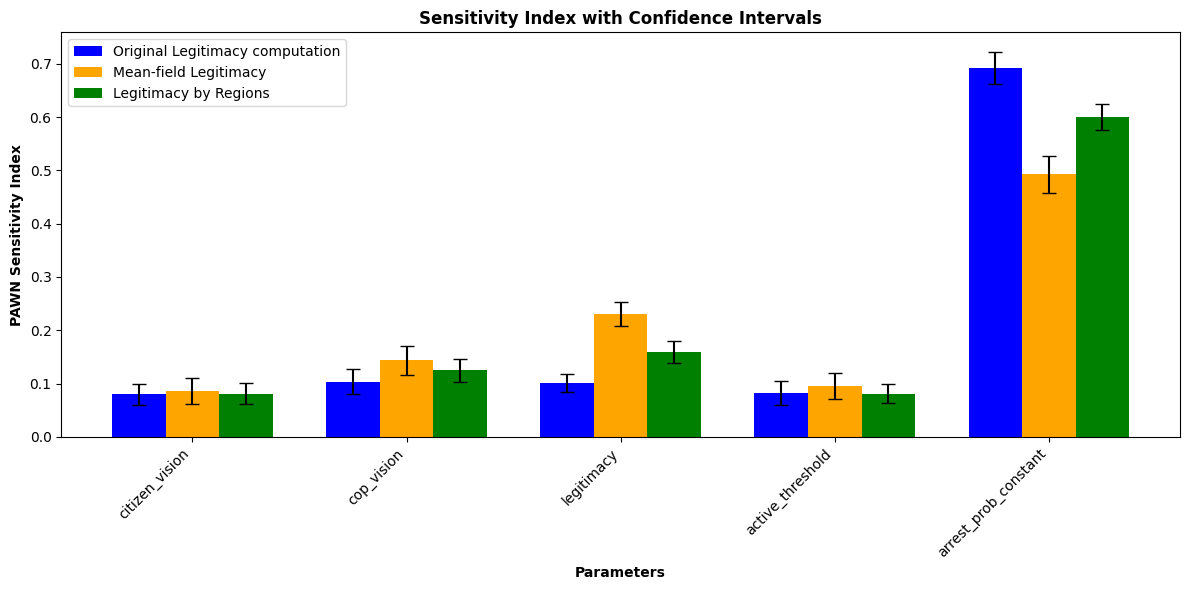

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# data
parameter_names = ['citizen_vision', 'cop_vision', 'legitimacy', 'active_threshold', 'arrest_prob_constant']
original_model = [0.07963232, 0.10365556, 0.10029798, 0.08224343, 0.6929]
legit_heterogeneous = [0.0863, 0.1436, 0.2302, 0.0952, 0.4929]
legit_by_regions = [0.08134, 0.12465, 0.15948, 0.08133, 0.5999]
confidence_intervals_original = [0.02, 0.023, 0.017, 0.022, 0.03]
confidence_intervals_legit_heterogeneous = [0.025, 0.027, 0.023, 0.025, 0.035]
confidence_intervals_legit_by_regions = [0.019, 0.021, 0.02, 0.018, 0.025]

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Define bar width
bar_width = 0.25

# Position of bars on x-axis
r1 = np.arange(len(parameter_names))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create bars
bars1 = ax.bar(r1, original_model, color='blue', width=bar_width, yerr=confidence_intervals_original, capsize=5, label='Original Legitimacy computation')
bars2 = ax.bar(r2, legit_heterogeneous, color='orange', width=bar_width, yerr=confidence_intervals_legit_heterogeneous, capsize=5, label='Mean-field Legitimacy')
bars3 = ax.bar(r3, legit_by_regions, color='green', width=bar_width, yerr=confidence_intervals_legit_by_regions, capsize=5, label='Legitimacy by Regions')

# Add labels and title
ax.set_xlabel('Parameters', fontweight='bold')
ax.set_ylabel('PAWN Sensitivity Index', fontweight='bold')
ax.set_title('Sensitivity Index with Confidence Intervals', fontweight='bold')

# Add xticks on the middle of the group bars
ax.set_xticks([r + bar_width for r in range(len(parameter_names))])
ax.set_xticklabels(parameter_names, rotation=45, ha="right", fontsize=10)

# Add legend
ax.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()
